In [1]:
import scipy.io
import mne
from scipy.signal import butter, filtfilt
import os
import numpy as np
from scipy import stats

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split



from matplotlib import pyplot as plt
mne.set_log_level('error')


In [2]:
data_root = 'C:/Data/UHD_EEG/'
subjects = ['S1', 'S2', 'S3', 'S4', 'S5']
dominant_hand = ['left','right','right','right','right']

mapping = {0: "No instruction", 1: "Rest", 2: "thumb", 3: "index", 4: "middle", 5: "ring", 6: "little"}

In [3]:
def get_montage(hemishpere):
    mat = scipy.io.loadmat(os.path.join(data_root, 'montage', f'montage_256_{hemishpere}_hemisphere.mat'))
    return mat['pos_256']

left_handed_montage = get_montage('right')
right_handed_montage = get_montage('left')

In [4]:
def load_run(subject_id, run, describe = True):
    # LOAD DATA
    #run = subject + '_run' + str(run) + '.mat'
    subject = subjects[subject_id]
    mat = scipy.io.loadmat(os.path.join(data_root, 'rawdata', subject, run))
    data = mat['y']
    data = data[1:] # remove timestamp
    ch_names = ['c' + str(i) for i in range(1, 257)]
    ch_names.append('STIM')
    info = mne.create_info(ch_names = ch_names, sfreq=mat['SR\x00'][0][0]) #, ch_types='eeg')
    raw = mne.io.RawArray(data, info)

    # SET CHANNEL TYPES
    for ch in info.ch_names:
        if ch != 'STIM':
            raw.set_channel_types({ch: 'eeg'})
        else:
            raw.set_channel_types({ch: 'stim'})

    events = mne.find_events(raw, stim_channel='STIM')
    annot_from_events = mne.annotations_from_events(events, event_desc=mapping, sfreq=raw.info['sfreq'])
    raw.set_annotations(annot_from_events)
    raw.drop_channels(['STIM'])

    # SET MONTAGE
    if dominant_hand[subject_id] == 'left':
        montage = left_handed_montage
    else:
        montage = right_handed_montage

    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, montage)), coord_frame='head')
    raw.set_montage(montage)

    if describe:
        raw.describe()
    return raw

In [5]:
def load_subject(subject_id, describe = True):
    runs = []
    run_files = os.listdir(os.path.join(data_root, 'rawdata', subjects[subject_id]))
    for file in run_files:
        runs.append(load_run(subject_id, file, describe))
    return runs

In [6]:
raw_runs = load_subject(subject_id = 0, describe = True)

<RawArray | 256 x 135559 (225.9 s), ~265.0 MB, data loaded>
 ch  name  type  unit        min         Q1     median         Q3        max
  0  c1    EEG   µV    -85493210937.50  -35441191406.25  1677024414.06  36613792968.75  81199593750.00
  1  c2    EEG   µV    -85721015625.00  -35531160156.25  1664257812.50  36644519531.25  81226898437.50
  2  c3    EEG   µV    -85876343750.00  -35615492187.50  1649694213.87  36730896484.38  81483765625.00
  3  c4    EEG   µV    -85769679687.50  -35548326171.88  1663018066.41  36666996093.75  81330179687.50
  4  c5    EEG   µV    -85758578125.00  -35550046875.00  1659248779.30  36668800781.25  81367742187.50
  5  c6    EEG   µV    -85414617187.50  -35385037109.38  1647537475.59  36503046875.00  80972781250.00
  6  c7    EEG   µV    -85671015625.00  -35482373046.88  1650583496.09  36601558593.75  81176257812.50
  7  c8    EEG   µV    -85453140625.00  -35408878906.25  1628080566.41  36478734375.00  80898117187.50
  8  c9    EEG   µV    -85142101562.50 

In [7]:
print(len(raw_runs))
print(type(raw_runs[0]))

10
<class 'mne.io.array.array.RawArray'>


In [100]:
raw_runs[0].annotations

<Annotations | 26 segments: Rest (1), index (5), little (5), middle (5), ...>

In [8]:
'''
Next, bad channels
and runs were identified based on EEG data during the task
period. 
'''

def find_bad_channels(raw, flat_threshold=1e-2, z_threshold = 6):
    """
    Identify and drop bad channels based on their standard deviation and z-score.
    
    Parameters:
    :param raw: Raw EEG data (MNE Raw object)
    threshold (float): Threshold for identifying bad channels (default: 3)

    Returns:
    bad_channels (list): List of bad channel indices
    """

    raw.set_eeg_reference('average', projection=True)

    raw = raw.filter(8, 25,  fir_design='firwin')

    bad_channels = []

    # Find flat channels based on the threshold
    variance = np.var(raw.get_data('eeg'), axis=1)
    flat_channels = [ch_name for ch_name, var in zip(raw.ch_names, variance) if var < flat_threshold]
    # Print the list of flat channels
    print("Flat channels found: ", flat_channels)
    bad_channels.extend(flat_channels)

    data = raw.get_data('eeg')

    bad_channels = []


    mean_powers = np.mean((data-data.mean(axis=1, keepdims=True))**2, axis=1)
    log_mean_powers = np.log10(mean_powers)
    z_scores = (log_mean_powers - log_mean_powers.mean()) / log_mean_powers.std()

    bad_channel_indices = np.where(np.abs(z_scores) > z_threshold)[0].tolist()
    
    print("Bad channels found: ", bad_channel_indices)
    bad_channels.extend(bad_channel_indices)
    return [raw.ch_names[i] for i in bad_channels]


In [9]:
def resample(run):
    '''
    The raw EEG recordings were first down-sampled from
    600 to 200 Hz (resample)
    '''
    run = run.resample(200)
    return run

def notch(run):
    '''
    notch-filtered at 60 Hz and its
    harmonics using a notch-filter cascade. 4th-order Butterworth
    filters were utilized, using butter to calculate filter coefficients
    and apply the filter coefficients to the signal.
    '''
    #run = run.notch_filter([60,120,180])
    f0  = 60
   
    order = 4

    # Design notch filter
    Q = 30  # Quality factor
    bw = f0 / Q  # Bandwidth
    b, a = butter(4, [f0 - bw / 2, f0 + bw / 2], fs=run.info['sfreq'], btype='bandstop')

    filtered = filtfilt(b, a, run.get_data())
    run._data = filtered
    return run

def preprocesss_runs(runs):
    run_bad_channels = []

    for run in runs:
        run = resample(run)
        run = notch(run)
        run_bad_channels.extend(find_bad_channels(run, flat_threshold=1e-2, z_threshold = 3))

    run_bad_channels = list(set(run_bad_channels)) # remove duplicates

    for run in runs:
        run.drop_channels(run_bad_channels)
    
    for run in runs:
        run = run.set_eeg_reference('average', projection=True)

    return runs


In [10]:
preprocessed_runs = preprocesss_runs(raw_runs)

Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Flat channels found:  []
Bad channels found:  [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Flat 

c:\Users\Nemes\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


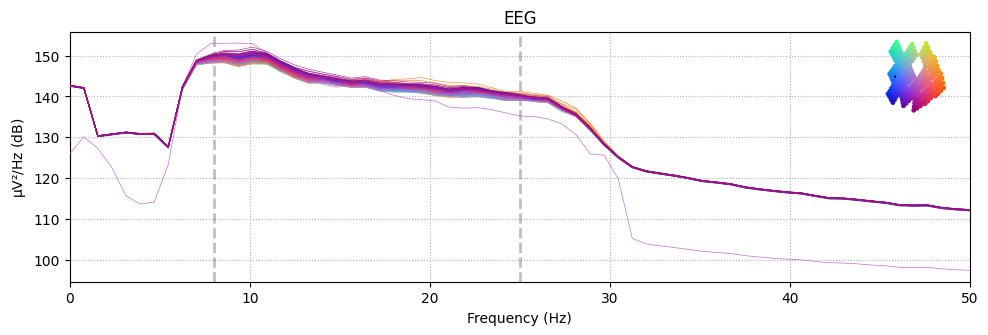

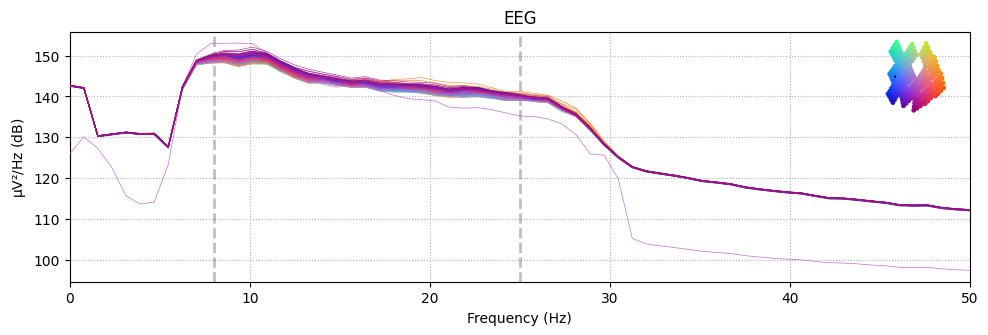

In [11]:
preprocessed_runs[0].plot_psd(fmin=0, fmax=50)

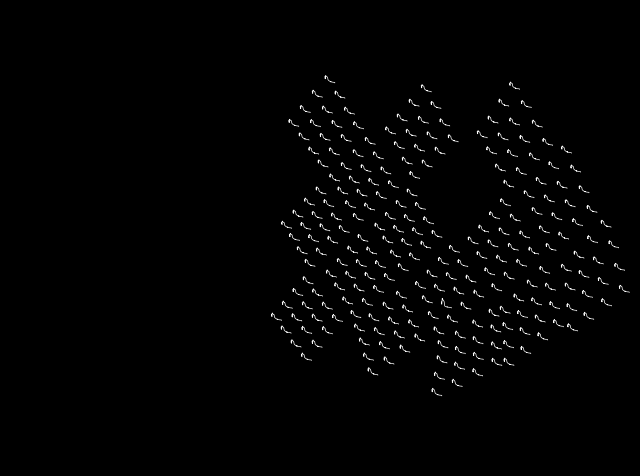

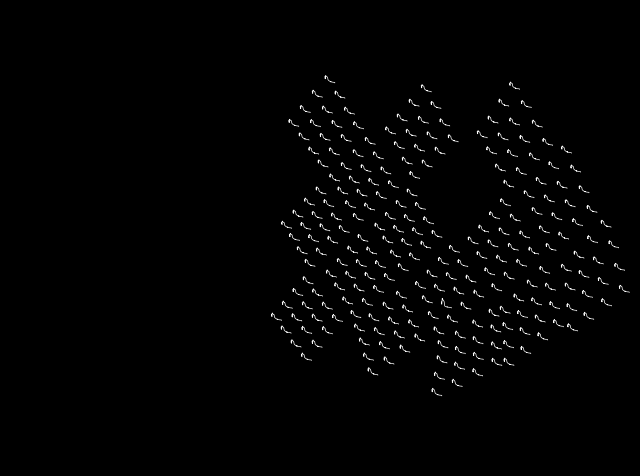

In [12]:
preprocessed_runs[0].plot_psd_topo()

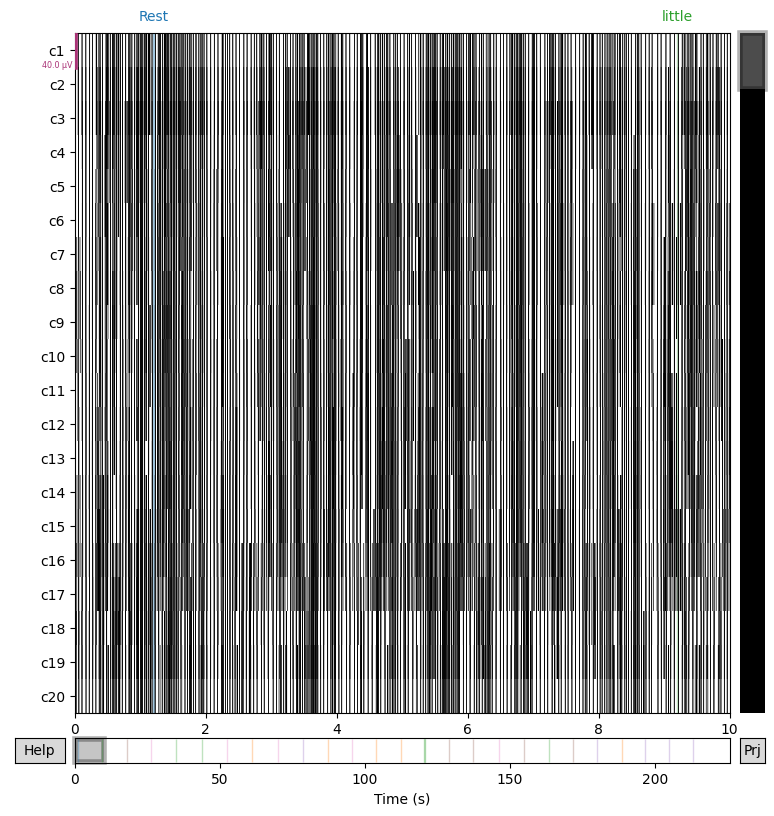

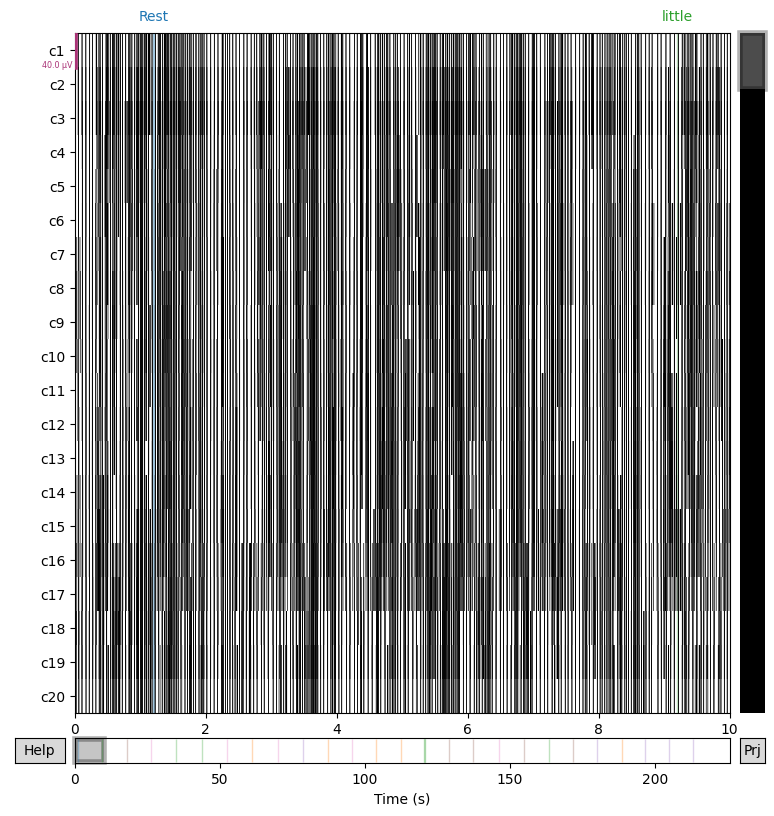

In [14]:
preprocessed_runs[0].plot()

In [13]:
preprocessed_runs[0]._data.shape

(240, 45186)

In [133]:
'''
The features extracted are band power features for the mu and beta bands,
as these frequency bands are associated with motor functions (Miller et al., 2010; Cheyne, 2013).
The EEG data were band-pass filtered for the respective frequency band, and the power was calculated
by squaring each time sample. Then the power was estimated in non-overlapping 0.25 s segments
by averaging the power samples and applying a centered moving average with a 0.75 s window length. 
A centered moving average was used instead of a causal moving average
in order to make the interpretation of results easier, as the latter would introduce time delays.
Again, band power features were log-transformed to improve Gaussianity because non-log-transformed band power features 
are Chisquared distributed. Finally, a power shift compensation was applied, subtracting the mean band power over 
the last 25 s. 
'''
def extract_features(source, plot = False):
    raw = source.copy()

    raw = raw.filter(l_freq=8, h_freq=12)

    # Alternatively, you can use the following code to extract events from annotations
    # events, event_ids = mne.events_from_annotations(raw)
    # #print(events[:10])
    # events[...,0]*= int(1000/(raw.info['sfreq']))
    # events_in_ms = events
    # #print(events_in_ms[:10])

    # Load EEG data
    filtered_eeg_data = raw.get_data()

    if plot:
        plt.plot(filtered_eeg_data[0])
        plt.show()
    # Calculate power by squaring each time sample
    power_eeg_data = np.square(filtered_eeg_data)

    baseline = power_eeg_data[...,-int(25*raw.info['sfreq']):]
    baseline = np.log10(baseline)
    baseline = baseline.mean(axis=-1, keepdims=True)
    
    # Define segment parameters
    segment_length = int(0.25 * raw.info['sfreq'])  # 0.25 s segment length 
    window_length = int(0.75 * raw.info['sfreq'])  # 0.75 s window length 

   
    num_to_drop = power_eeg_data.shape[-1] % segment_length

        
    power_eeg_data = power_eeg_data[...,:-num_to_drop] 
    
    #print(power_eeg_data.shape)

    power_eeg_data = power_eeg_data.reshape(power_eeg_data.shape[0], -1, segment_length)

    #print(power_eeg_data.shape)

    # Estimate power in non-overlapping segments using centered moving average
    power_eeg_data = np.mean(power_eeg_data, axis=-1)
    #print(power_eeg_data.shape)

    

    def moving_average(data, window_size):
        cumsum = np.cumsum(data, axis=-1)
        cumsum[..., window_size:] = cumsum[..., window_size:] - cumsum[..., :-window_size]
        return (cumsum[..., window_size - 1:] / window_size)

    if plot:
        plt.plot(power_eeg_data[0])
        plt.show()
    result = moving_average(power_eeg_data, 3)
    if plot:
        plt.plot(result[0])
        plt.show()

    # Log-transform the band power features
    result = np.log10(result)
    
    # Finally, a power shift compensation was applied, subtracting the mean band power over the last 25 s

    result = result - baseline
    
    
    ### SUPER NOT SURE ABOUT THIS
    raw.resample(4)
    raw.crop(0.25)
    
    # print(result.shape)
    # print(raw._data.shape)
    raw._data = result
    return raw




#print("preprocessed_runs[0].shape: ", preprocessed_runs[0]._data.shape)
featured = extract_features(source=preprocessed_runs[0])

(240, 903)


c:\Users\Nemes\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


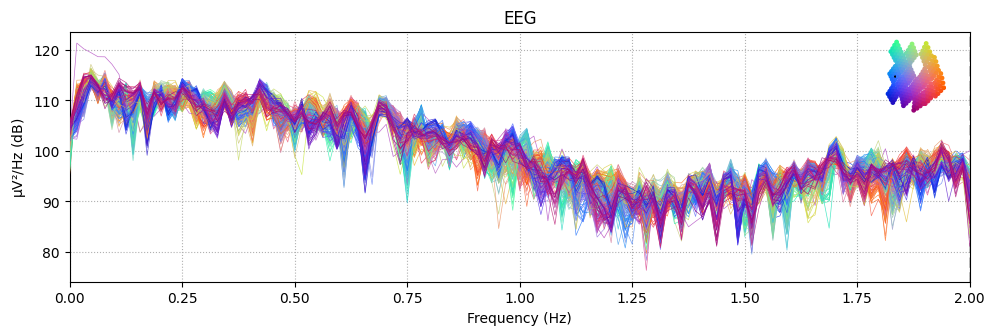

In [135]:
featured.plot_psd(fmin=0, fmax=2)


In [136]:
features_of_runs = []
for run in preprocessed_runs:
    features_of_runs.append(extract_features(run))

(240, 903)
(240, 898)


C:\Users\Nemes\AppData\Local\Temp\ipykernel_2588\4179364719.py:34: RuntimeWarning: divide by zero encountered in log10
  baseline = np.log10(baseline)


(240, 939)
(240, 904)
(240, 925)
(240, 902)
(240, 912)
(240, 906)
(240, 895)
(240, 904)


In [137]:
type(preprocessed_runs[0])
preprocessed_runs[0].annotations

<Annotations | 26 segments: Rest (1), index (5), little (5), middle (5), ...>

In [144]:
epochs = []
for run in features_of_runs:
    events, event_ids = mne.events_from_annotations(run)
    # Create epochs from the raw data
    # print("events: ", events[-10:])
    # print("event_ids: ", event_ids)
    # print("run: ", run._data.shape)
    asd = mne.Epochs(run, events, baseline = None, event_id= event_ids, tmin=-0.5, tmax=7, preload=True)
    epochs.append(asd)
epochs = mne.concatenate_epochs(epochs)

In [145]:
epochs

Number of events,260
Events,Rest: 10index: 50little: 50middle: 50ring: 50thumb: 50
Time range,-0.500 – 7.000 sec
Baseline,off
